In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
df = pd.read_csv("TCGA.STAD.mutations.txt", sep="\t")



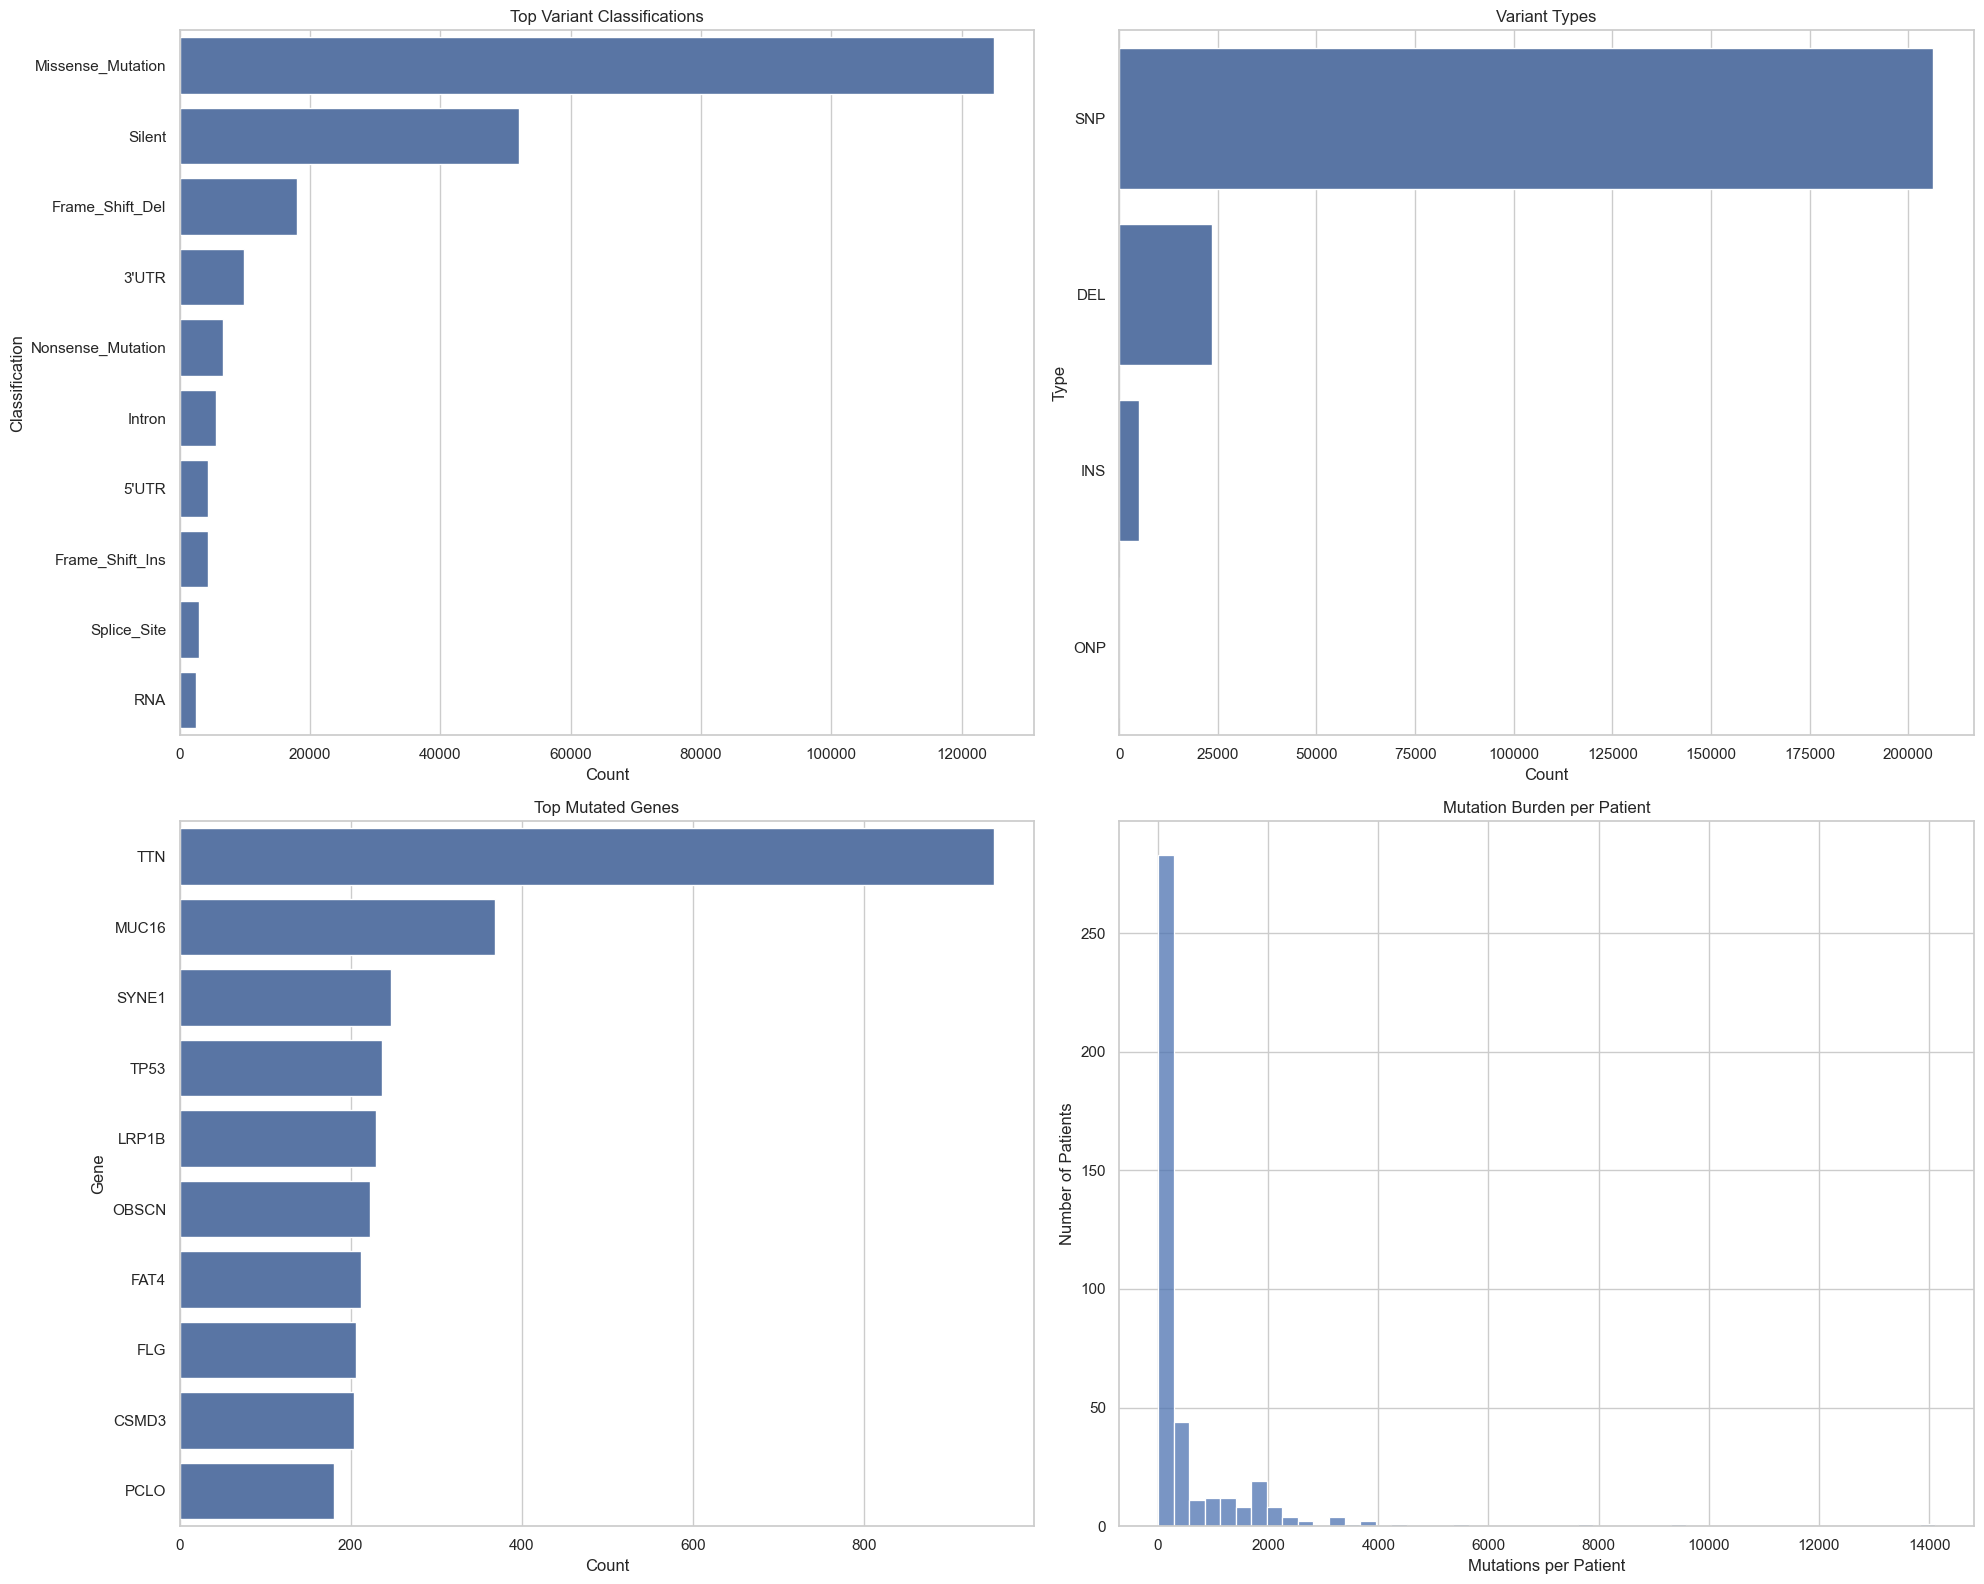

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clean column names
df.columns = df.columns.str.strip()

# Set consistent style
sns.set(style="whitegrid")
plt.figure(figsize=(20, 16))

# 1. Variant Classification
plt.subplot(2, 2, 1)
vc_counts = df['Variant_Classification'].value_counts().head(10)
sns.barplot(x=vc_counts.values, y=vc_counts.index)
plt.title("Top Variant Classifications")
plt.xlabel("Count")
plt.ylabel("Classification")

# 2. Variant Type
plt.subplot(2, 2, 2)
vt_counts = df['Variant_Type'].value_counts()
sns.barplot(x=vt_counts.values, y=vt_counts.index)
plt.title("Variant Types")
plt.xlabel("Count")
plt.ylabel("Type")

# 3. Top Mutated Genes
plt.subplot(2, 2, 3)
gene_counts = df['Hugo_Symbol'].value_counts().head(10)
sns.barplot(x=gene_counts.values, y=gene_counts.index)
plt.title("Top Mutated Genes")
plt.xlabel("Count")
plt.ylabel("Gene")

# 4. Mutation Burden per Patient
plt.subplot(2, 2, 4)
patient_counts = df['patient_id'].value_counts()
sns.histplot(patient_counts, bins=50, kde=False)
plt.title("Mutation Burden per Patient")
plt.xlabel("Mutations per Patient")
plt.ylabel("Number of Patients")

plt.tight_layout()
plt.show()


In [7]:
print(mutation_counts.columns.tolist())
# Count mutations per patient
mutation_counts = df['patient_id'].value_counts().sort_index()



NameError: name 'mutation_counts' is not defined

Log10 split: 2.858
Exact split: 721 mutations


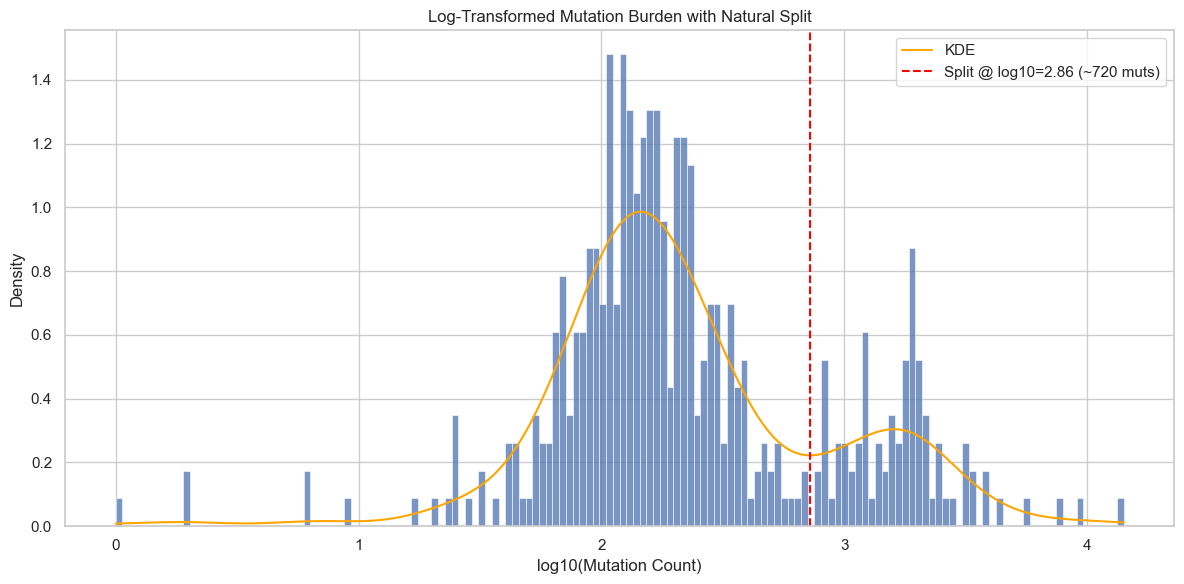

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Get mutation counts > 0
counts_array = mutation_counts[mutation_counts > 0].values.astype(float)
log_counts = np.log10(counts_array)

# KDE
kde = gaussian_kde(log_counts)
x_vals = np.linspace(log_counts.min(), log_counts.max(), 1000)
kde_vals = kde(x_vals)

# Restrict search to real bimodal region (log10 ≈ 1.5 to 3.5)
mask = (x_vals > 1.5) & (x_vals < 3.5)
x_zoom = x_vals[mask]
kde_zoom = kde_vals[mask]

# Find trough (local minimum)
troughs, _ = find_peaks(-kde_zoom)
if len(troughs) > 0:
    log_split = x_zoom[troughs[0]]
    exact_split = 10**log_split
    print(f"Log10 split: {log_split:.3f}")
    print(f"Exact split: {exact_split:.0f} mutations")
else:
    log_split = None
    print("No trough found.")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(log_counts, bins=150, kde=False, stat="density")
plt.plot(x_vals, kde_vals, color='orange', label='KDE')

# Plot vertical line for the split
if log_split:
    plt.axvline(log_split, color='red', linestyle='--', label=f"Split @ log10={log_split:.2f} (~{int(exact_split)} muts)")

plt.xlabel("log10(Mutation Count)")
plt.ylabel("Density")
plt.title("Log-Transformed Mutation Burden with Natural Split")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Get histogram bin edges from the KDE-aligned plot
hist_bins = np.histogram_bin_edges(log_counts, bins=50)

# Convert log bins to linear mutation counts
linear_bins = 10 ** hist_bins

# Find the largest bin edge that is still less than the exact split
bin_aligned_split = linear_bins[linear_bins < exact_split].max()

print(f"Adjusted split (previous bin edge): {bin_aligned_split:.0f} mutations")


In [9]:
# Threshold based on natural split
threshold = 663  # or use int(exact_split) from your earlier KDE step

# Create mutation count dataframe
mutation_counts = df['patient_id'].value_counts().sort_index()
mutation_split_df = mutation_counts.to_frame(name="mutation_count")

# Assign groups
mutation_split_df["mutation_group"] = mutation_split_df["mutation_count"].apply(
    lambda x: "High" if x >= threshold else "Low"
)

# Split into patient ID lists
low_patients = mutation_split_df[mutation_split_df["mutation_group"] == "Low"].index.tolist()
high_patients = mutation_split_df[mutation_split_df["mutation_group"] == "High"].index.tolist()

# Filter original mutation rows
low_mut = df[df['patient_id'].isin(low_patients)]
high_mut = df[df['patient_id'].isin(high_patients)]

# Build mutation matrix
def build_mutation_matrix(df, context_col="CONTEXT", sample_col="patient_id"):
    mutation_matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return mutation_matrix

# Create the matrices
low_matrix = build_mutation_matrix(low_mut)
high_matrix = build_mutation_matrix(high_mut)


In [ ]:
from sklearn.decomposition import NMF

# Choose matrix: low or high
X = high_matrix.values  # or low_matrix.values
model = NMF(n_components=2, init='nndsvd', random_state=0, max_iter=1000)
W = model.fit_transform(X)  # patient × signature
H = model.components_       # signature × context

# Plot signatures
plt.figure(figsize=(12, 4))
for i, row in enumerate(H):
    plt.subplot(1, H.shape[0], i + 1)
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), high_matrix.columns, rotation=90)
    plt.tight_layout()


In [ ]:
print("W shape:", W.shape)  # rows: patients, columns: signatures
print("H shape:", H.shape)  # rows: signatures, columns: mutation contexts


In [80]:
# 1. Filter to SNPs
low_mut_filt = low_mut[low_mut.Variant_Type == "SNP"].copy()
high_mut_filt = high_mut[high_mut.Variant_Type == "SNP"].copy()

# 2. Extract reference trinucleotide context
low_mut_filt["context_tri_ref"] = low_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
high_mut_filt["context_tri_ref"] = high_mut_filt["CONTEXT"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])

# 3. Build mutated trinucleotide: ref[0] + ALT + ref[2]
low_mut_filt["context_tri_mut"] = low_mut_filt["context_tri_ref"].str[0] + \
                                  low_mut_filt["Tumor_Seq_Allele2"].str[0] + \
                                  low_mut_filt["context_tri_ref"].str[2]

high_mut_filt["context_tri_mut"] = high_mut_filt["context_tri_ref"].str[0] + \
                                   high_mut_filt["Tumor_Seq_Allele2"].str[0] + \
                                   high_mut_filt["context_tri_ref"].str[2]

# 4. Full mutation context: ref>mut
low_mut_filt["context_full"] = low_mut_filt["context_tri_ref"] + ">" + low_mut_filt["context_tri_mut"]
high_mut_filt["context_full"] = high_mut_filt["context_tri_ref"] + ">" + high_mut_filt["context_tri_mut"]


In [81]:
def build_mutation_matrix(df, sample_col="Tumor_Sample_Barcode", context_col="context_full"):
    matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return matrix
low_matrix = build_mutation_matrix(low_mut_filt)
high_matrix = build_mutation_matrix(high_mut_filt)



In [88]:
#CURRENT BEST FUNCTION 5/13 7:40
def run_nmf_grid_search(matrix, matrix_name=""):
    # Collapse duplicate context columns (e.g. multiple patients with same "ACA>ATA")
    matrix = matrix.groupby(matrix.columns, axis=1).sum()

    # Filter out rare contexts (total count across all patients <= 10)
    context_sums = matrix.sum()
    filtered_contexts = context_sums[context_sums > 10].index.tolist()

    if len(filtered_contexts) < 2:
        print(f"[{matrix_name}] Too few contexts after filtering. Skipping NMF.")
        return None, None, None

    X = matrix[filtered_contexts].values

    results = []
    for n_components, init, solver, max_iter in itertools.product(
        range(2, 9), ['random', 'nndsvd'], ['mu', 'cd'], [200, 300, 500]
    ):
        try:
            model = NMF(n_components=n_components, init=init, solver=solver,
                        max_iter=max_iter, random_state=0)
            W = model.fit_transform(X)
            H = model.components_
            recon_err = model.reconstruction_err_

            if W.shape[0] > n_components:
                sil = silhouette_score(W, np.argmax(W, axis=1))
            else:
                sil = np.nan

            results.append({
                'matrix': matrix_name,
                'n_components': n_components,
                'init': init,
                'solver': solver,
                'max_iter': max_iter,
                'reconstruction_err': recon_err,
                'silhouette': sil
            })
        except Exception as e:
            print(f"Skipped ({matrix_name}, {n_components}, {init}, {solver}, {max_iter}): {e}")

    results_df = pd.DataFrame(results)

    # Add a fallback if all silhouettes are bad
    filtered_results = results_df[results_df['silhouette'] > 0.05]
    if not filtered_results.empty:
        best = filtered_results.sort_values(['reconstruction_err', 'silhouette'], ascending=[True, False]).iloc[0]
    else:
        print(f"[{matrix_name}] Warning: no good silhouette scores. Falling back to best reconstruction.")
        best = results_df.sort_values('reconstruction_err').iloc[0]

    # Re-run with best parameters
    best_model = NMF(
        n_components=int(best['n_components']),
        init=best['init'],
        solver=best['solver'],
        max_iter=int(best['max_iter']),
        random_state=0
    )
    W = best_model.fit_transform(X)
    H = best_model.components_

    # Plot mutation signatures
    plt.figure(figsize=(25, 4))
    for i, row in enumerate(H):
        plt.figure(figsize=(20, 5))  # One row per figure, wide format
        plt.bar(range(len(row)), row)
        plt.title(f'{matrix_name} Signature {i+1}', fontsize=16)
        plt.xticks(range(len(row)), filtered_contexts, rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()


    print(f"\nBest NMF config for {matrix_name}:")
    print(best)

    return best, W, H


<Figure size 2500x400 with 0 Axes>

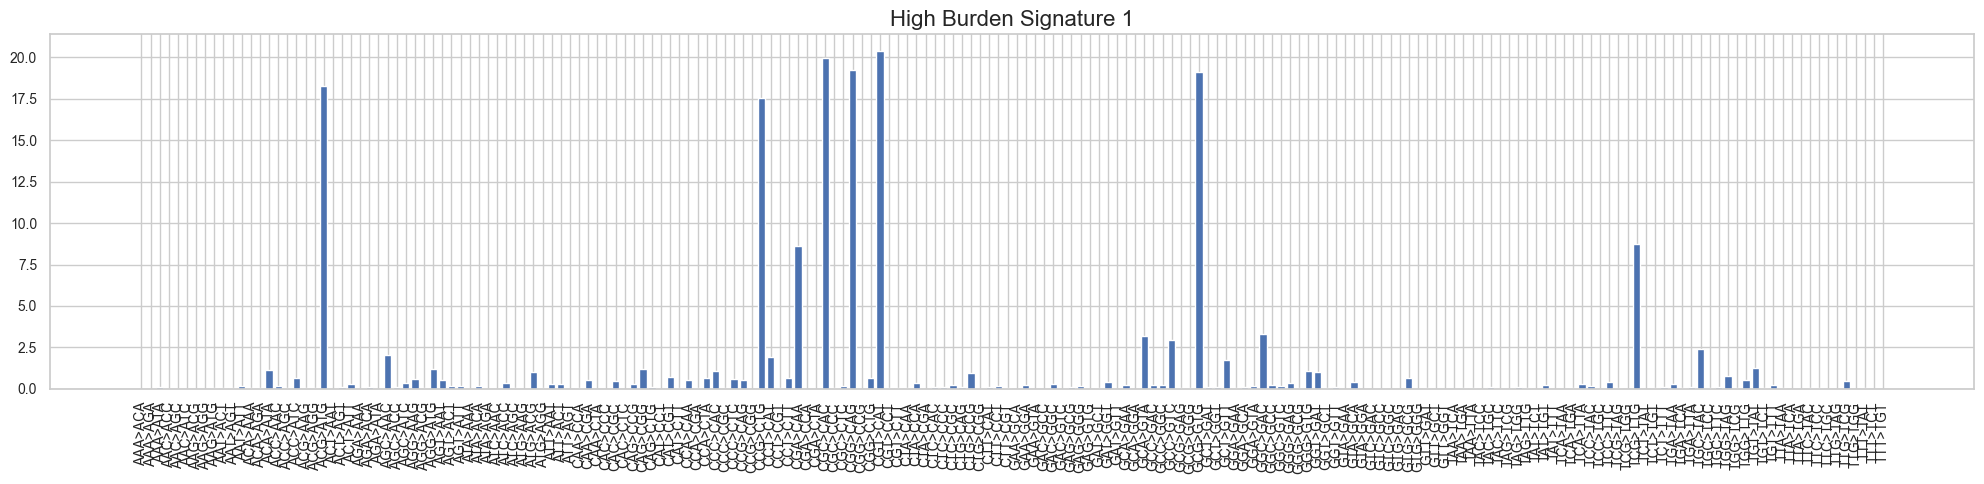

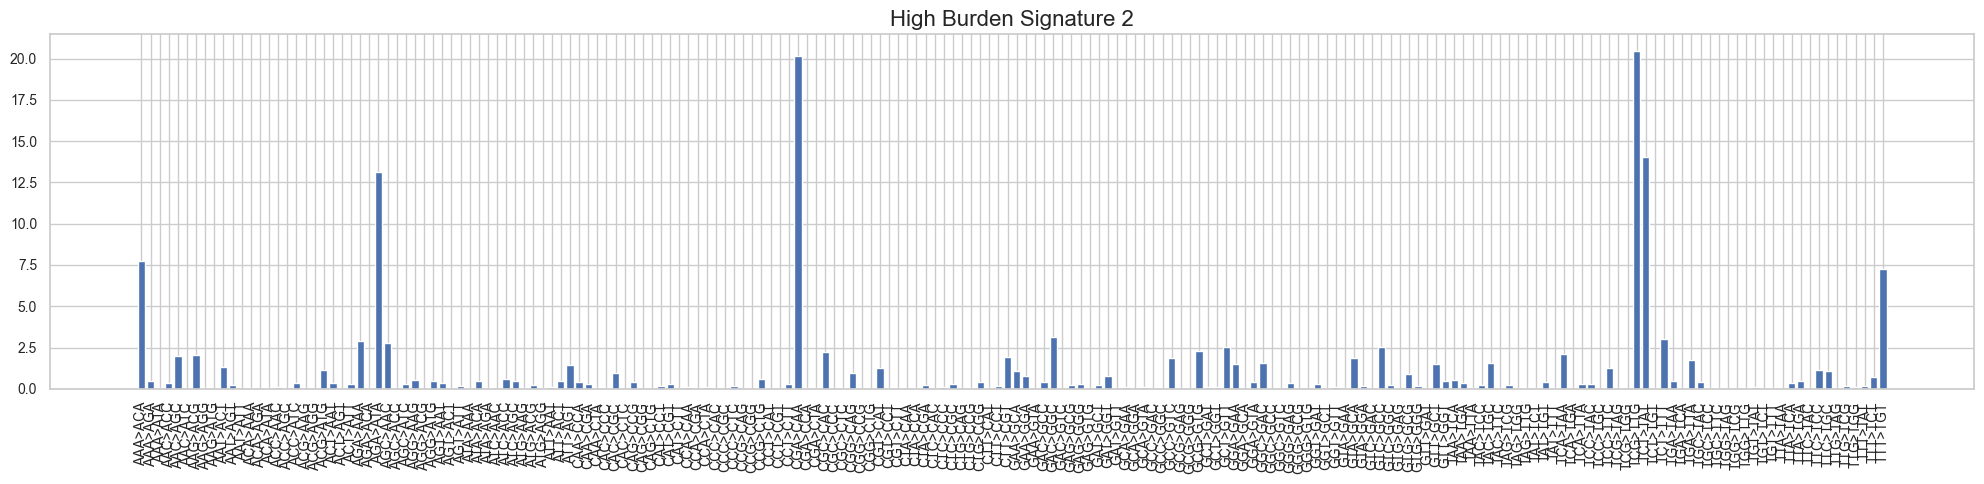

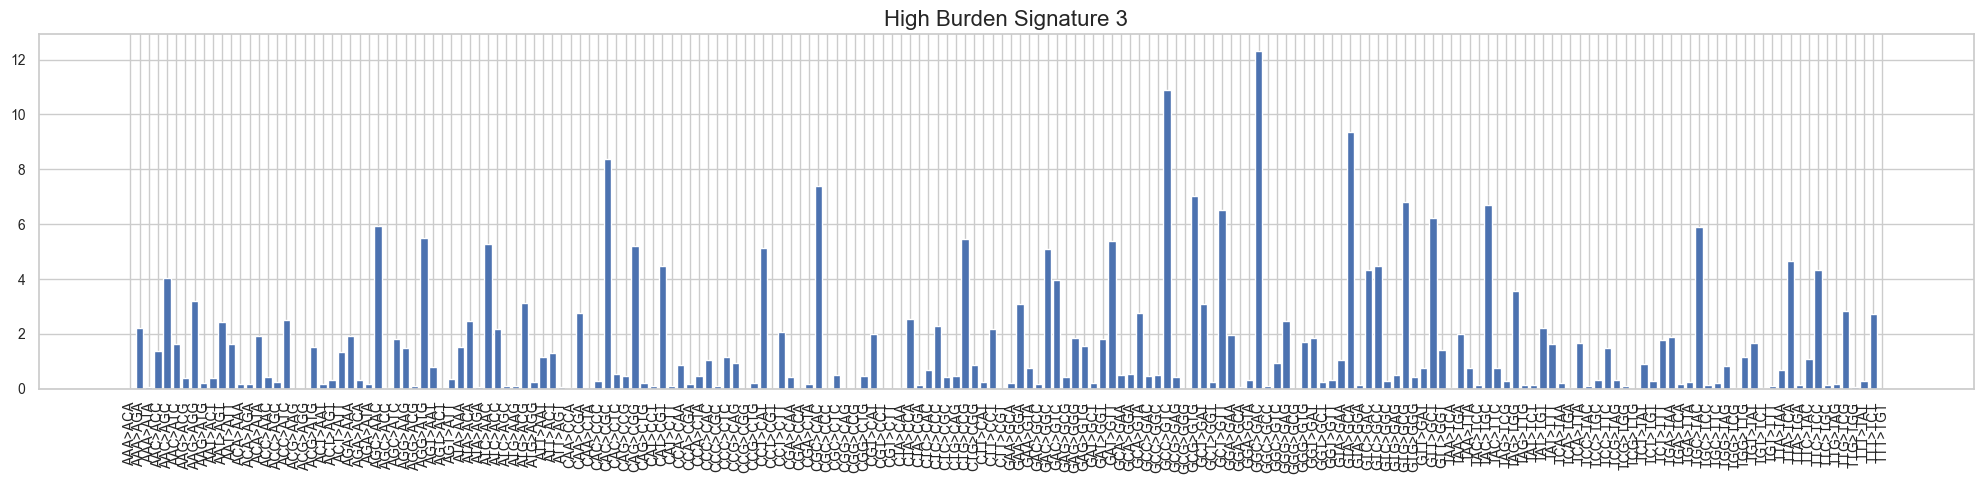

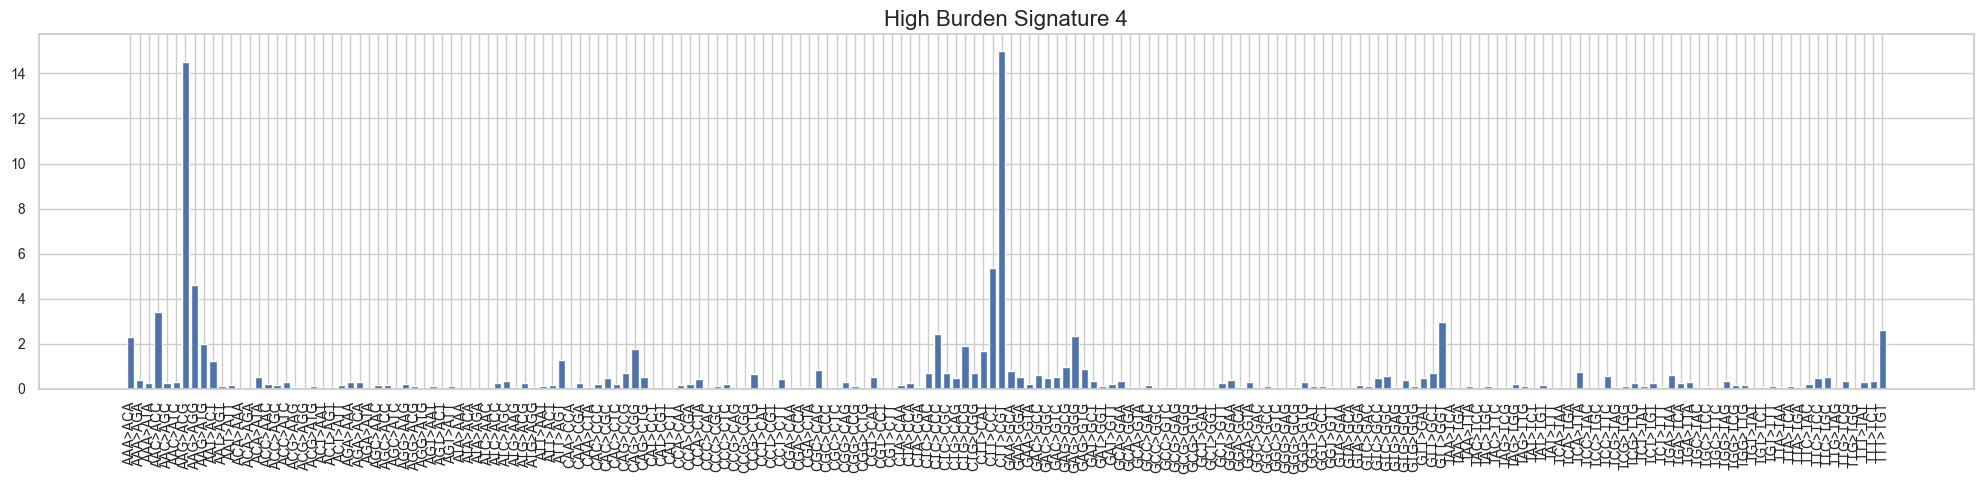

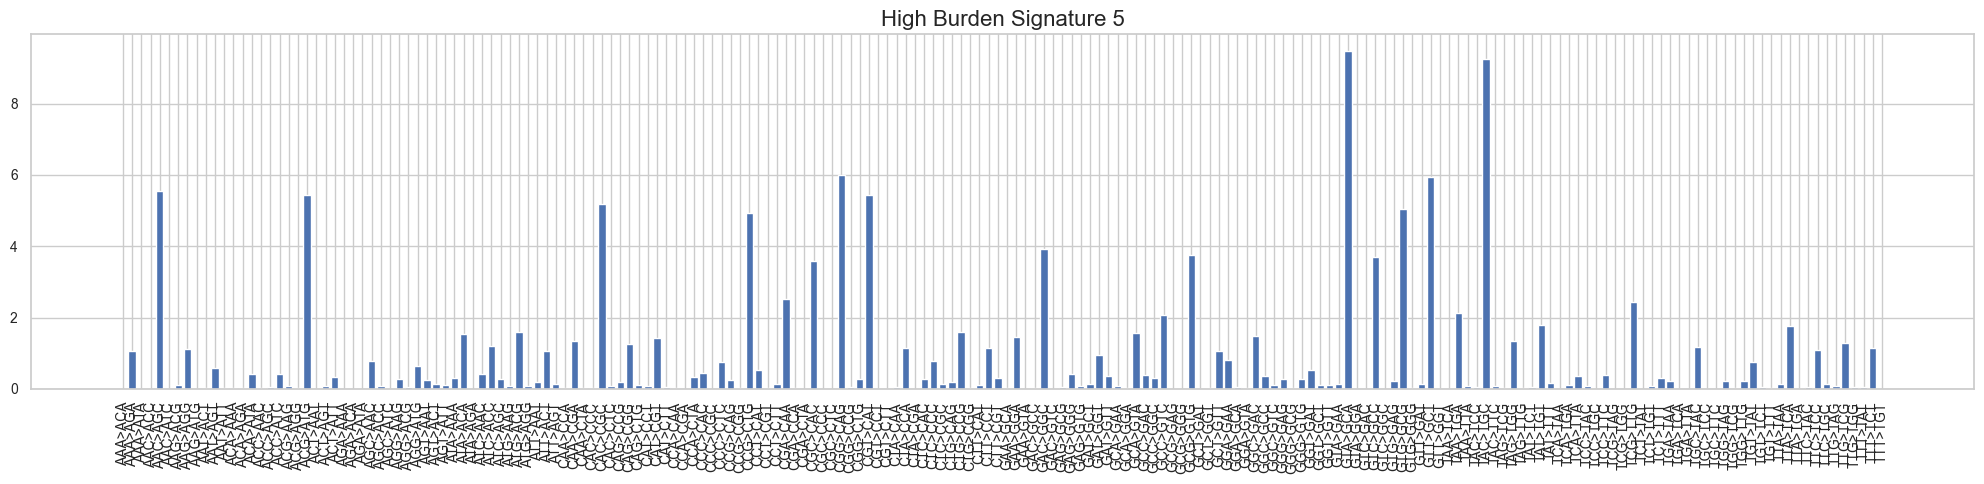

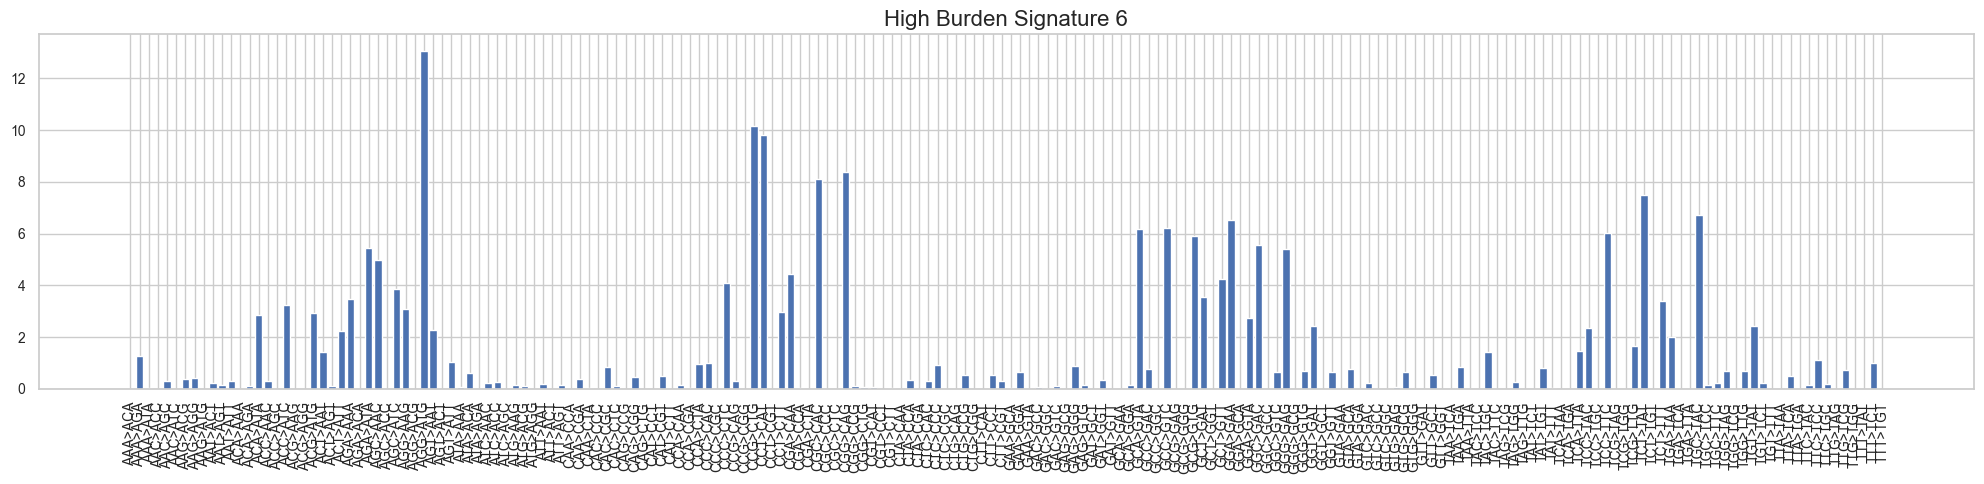

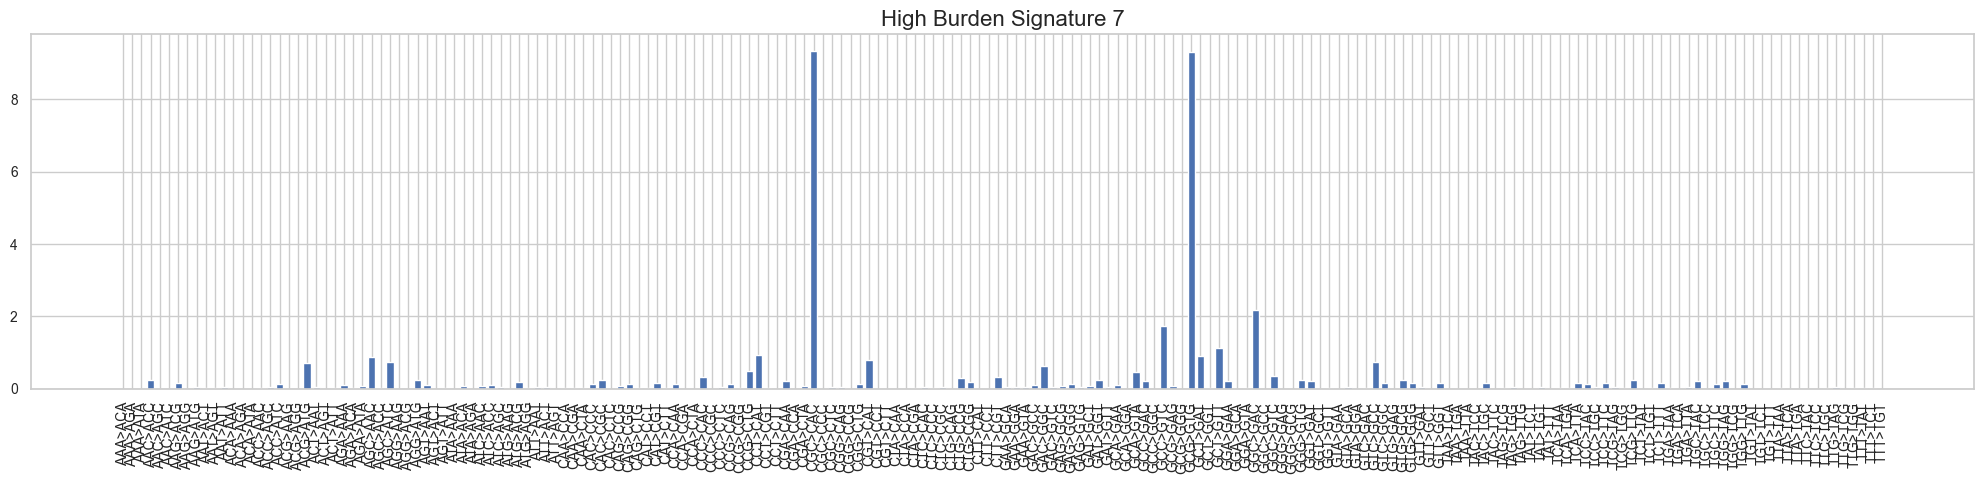

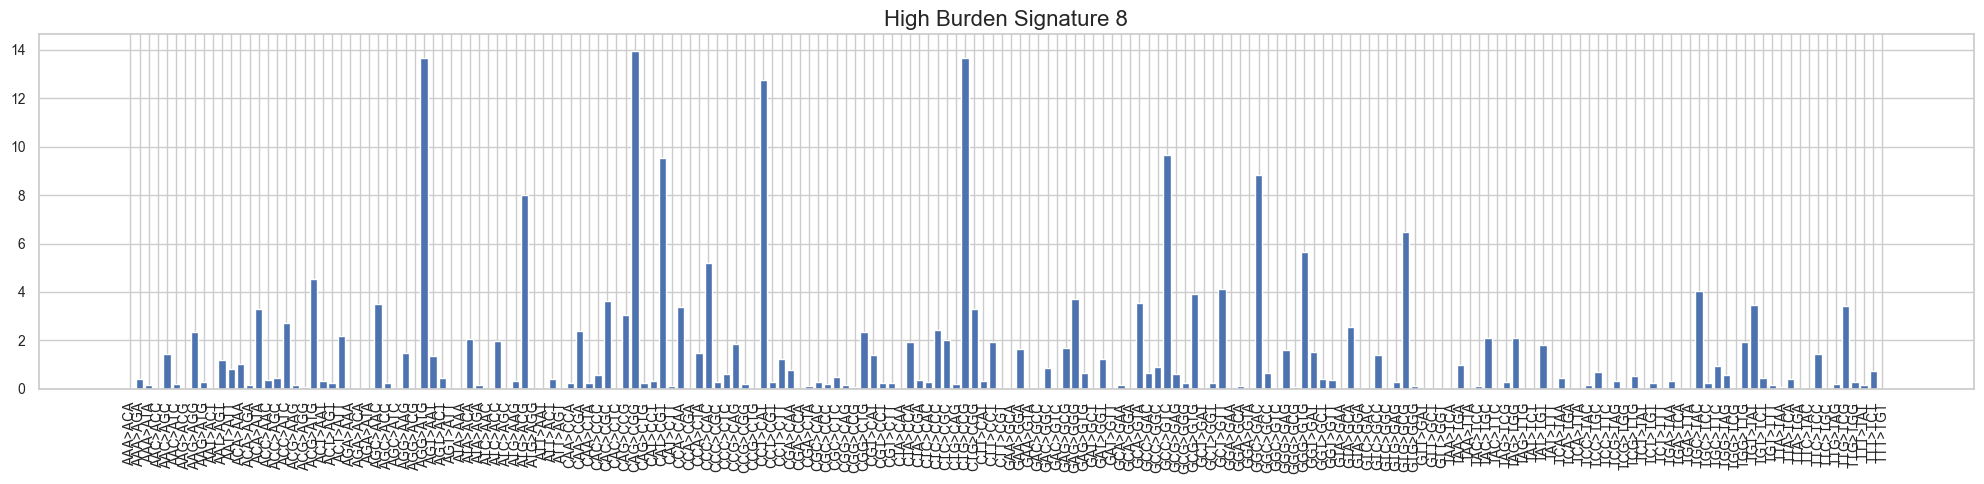


Best NMF config for High Burden:
matrix                High Burden
n_components                    8
init                       nndsvd
solver                         cd
max_iter                      500
reconstruction_err     363.215241
silhouette                0.25023
Name: 83, dtype: object


<Figure size 2500x400 with 0 Axes>

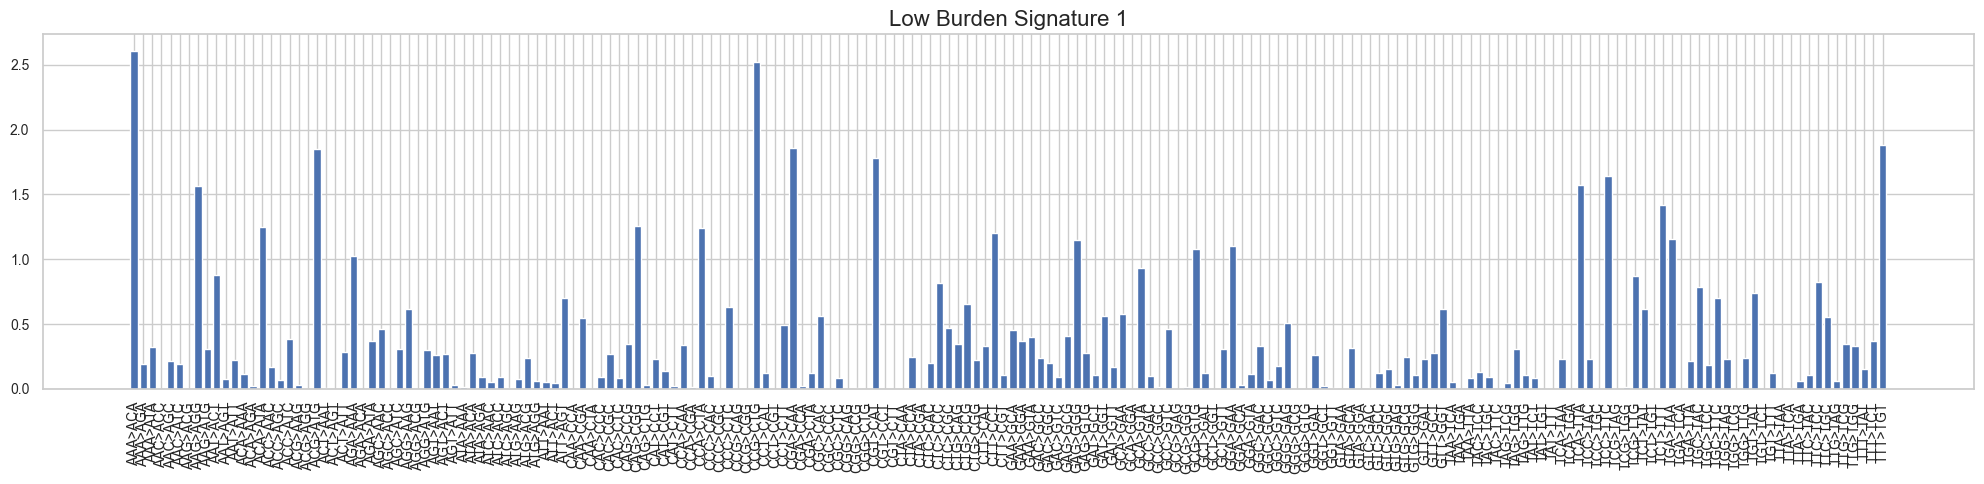

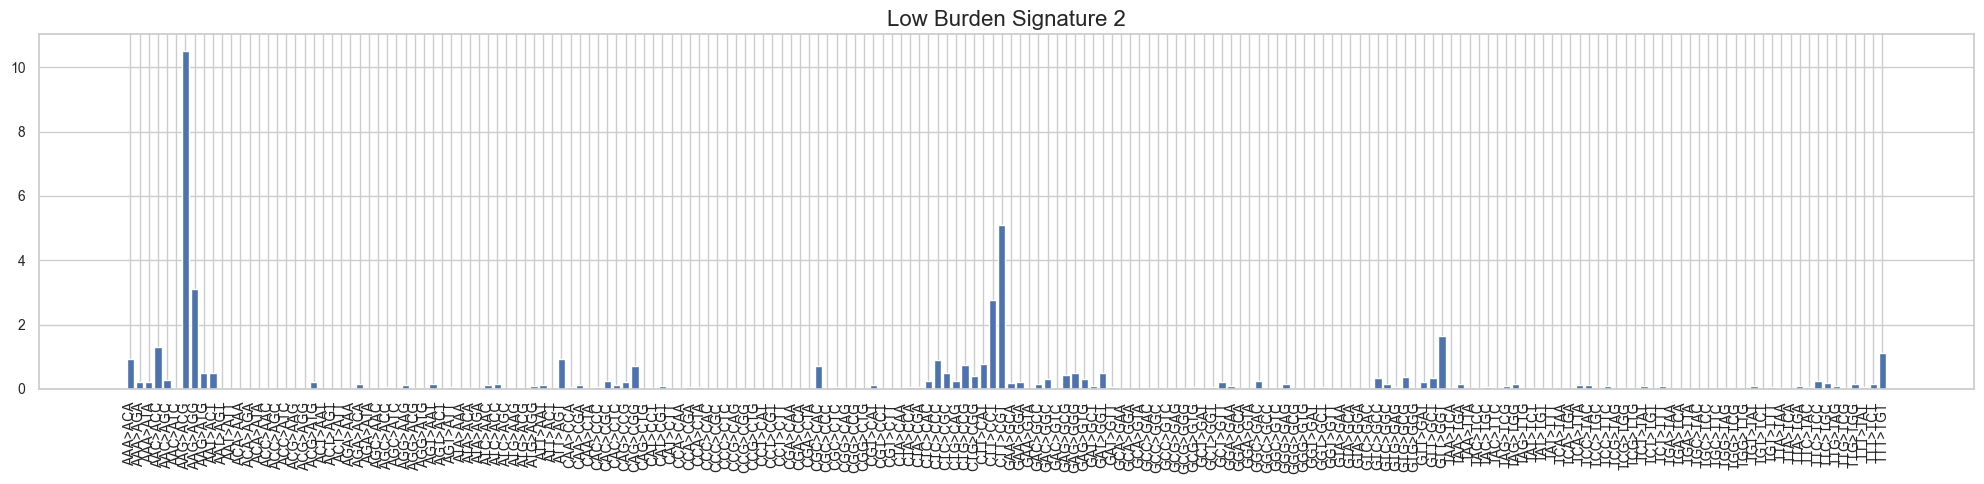

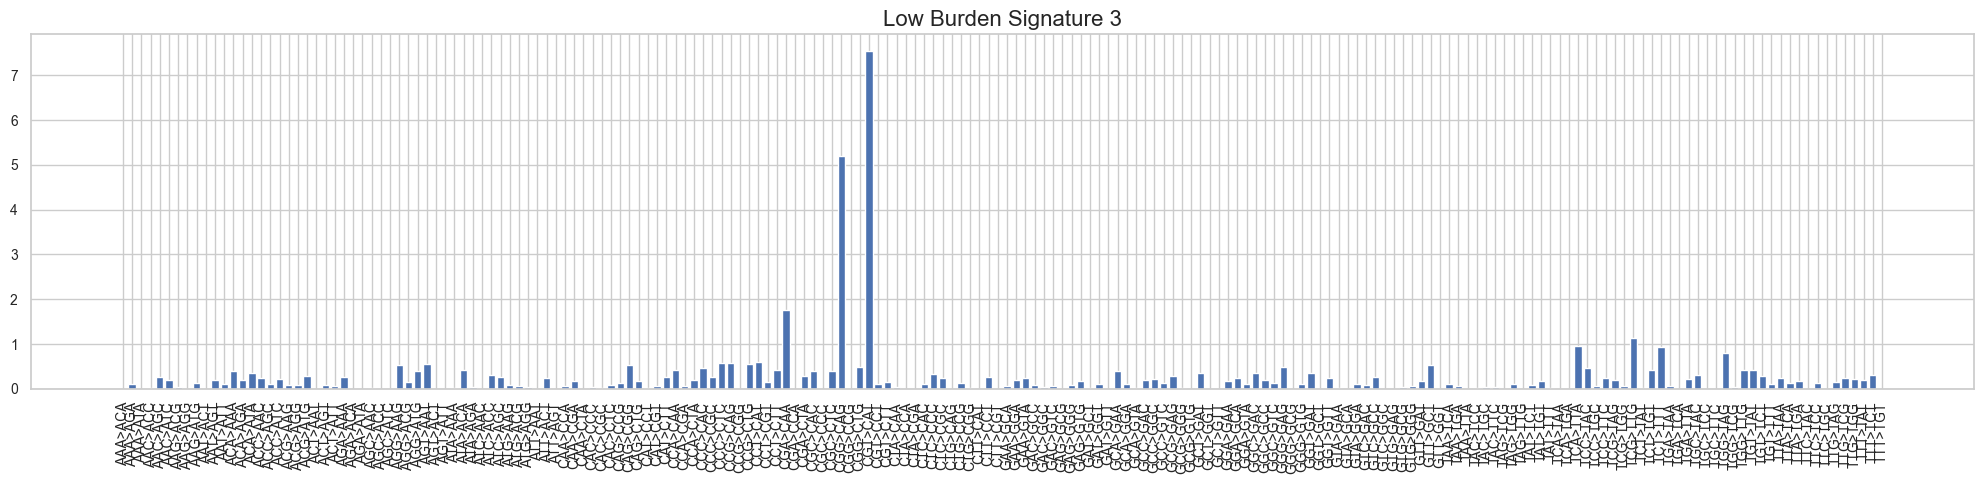

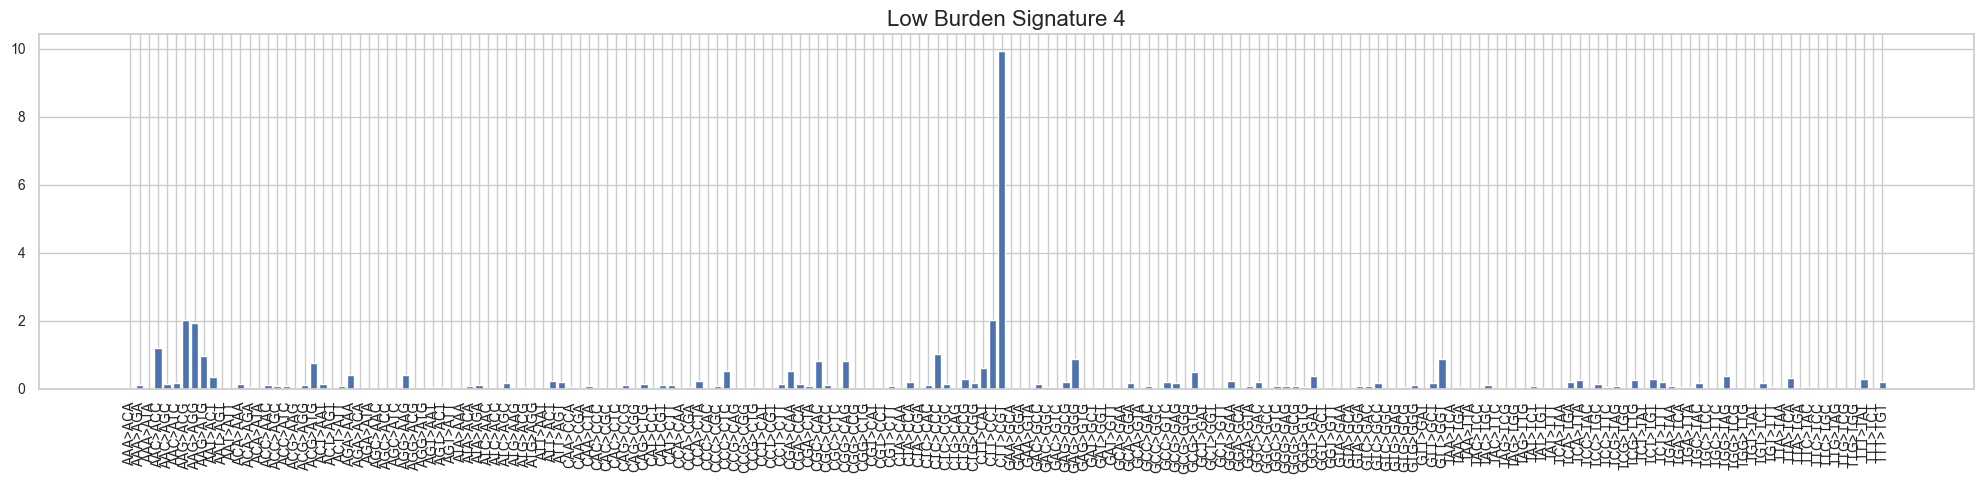

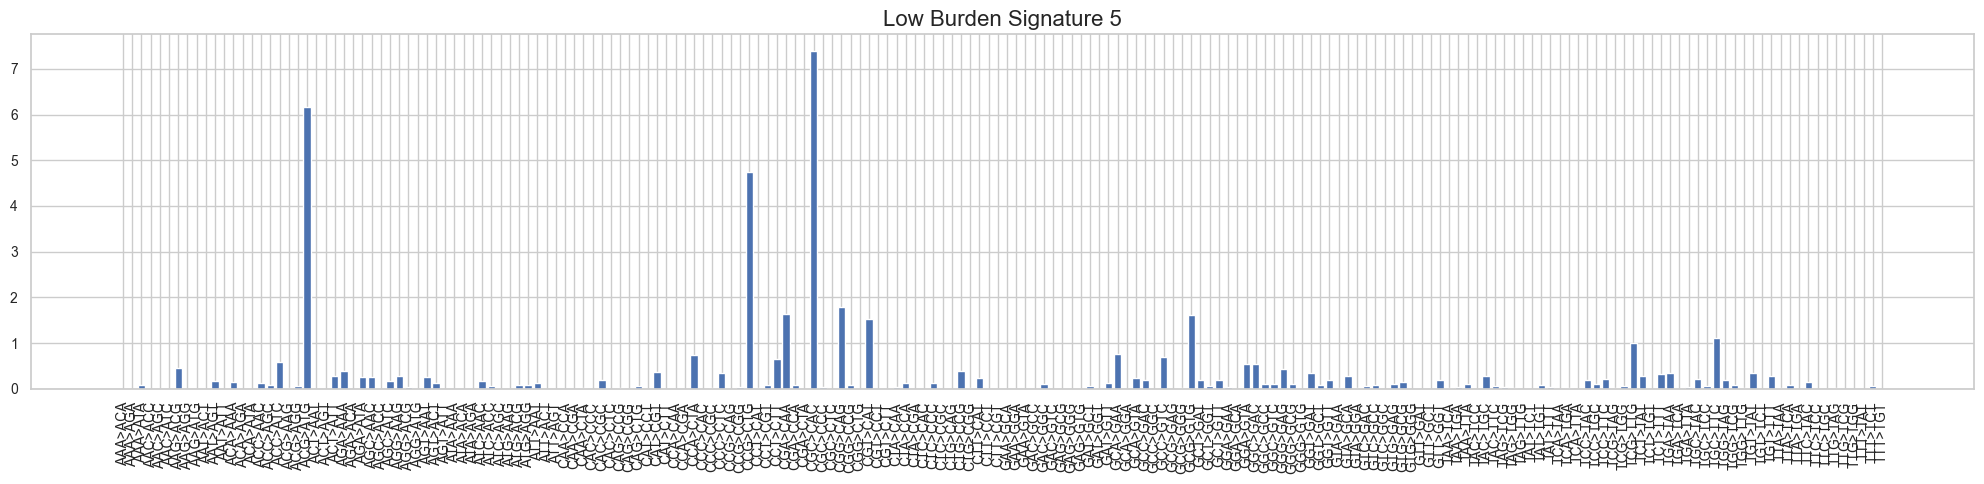

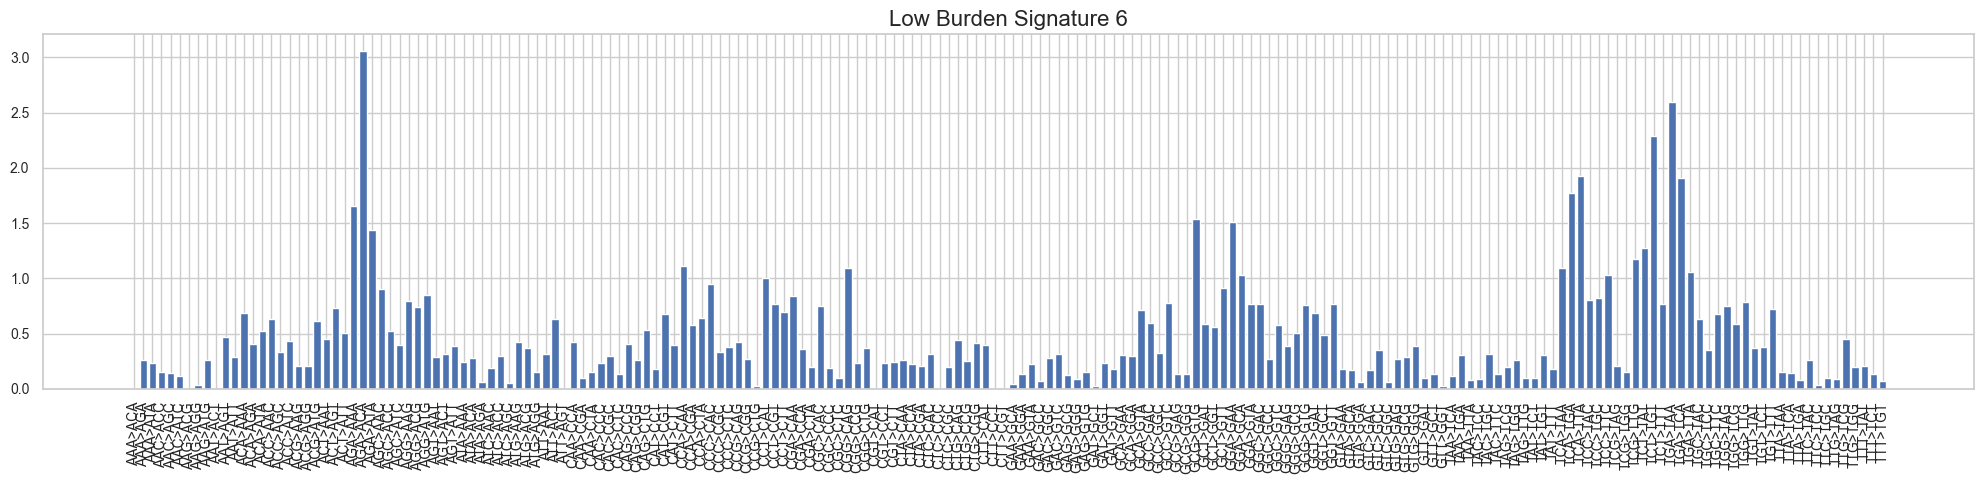

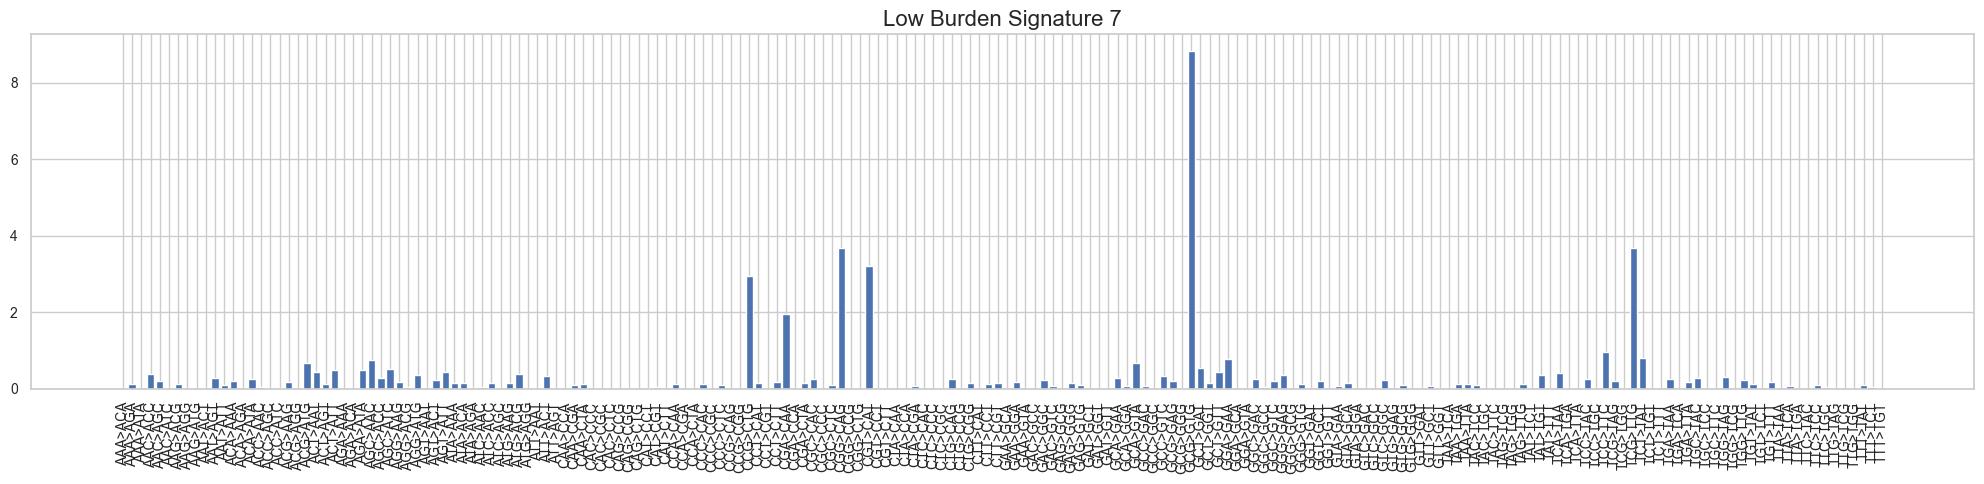


Best NMF config for Low Burden:
matrix                Low Burden
n_components                   7
init                      random
solver                        mu
max_iter                     300
reconstruction_err    234.035298
silhouette              0.055073
Name: 61, dtype: object


In [89]:
high_matrix = build_mutation_matrix(high_mut_filt)  # using context_full
low_matrix = build_mutation_matrix(low_mut_filt)

best_high, W_high, H_high = run_nmf_grid_search(high_matrix, matrix_name="High Burden")
best_low, W_low, H_low = run_nmf_grid_search(low_matrix, matrix_name="Low Burden")


In [38]:
print(f"Number of samples in high_matrix: {high_matrix.shape[0]}")
print(f"Number of samples in low_matrix: {low_matrix.shape[0]}")


Number of samples in high_matrix: 86
Number of samples in low_matrix: 329


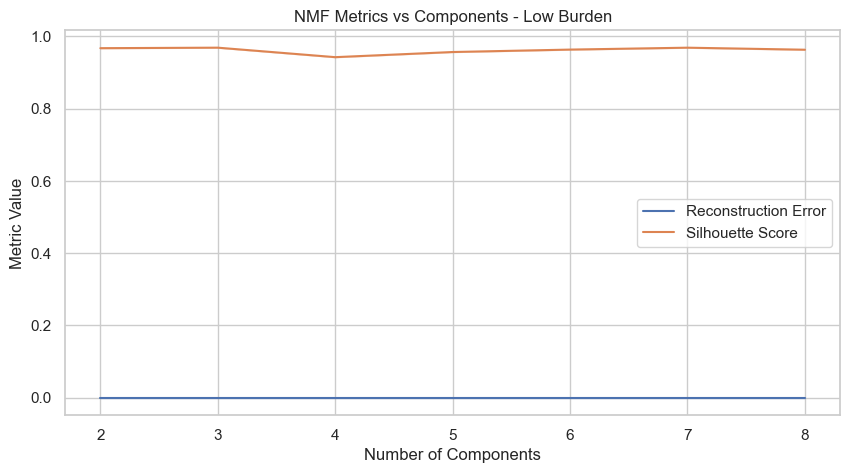

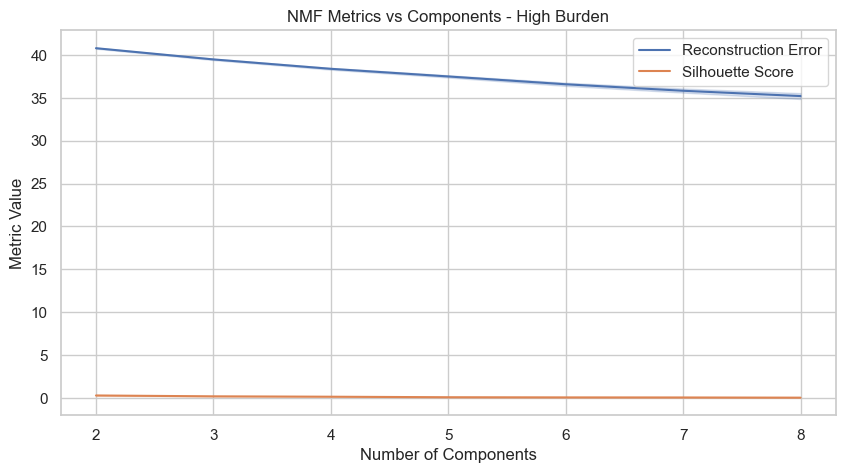

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_nmf_metrics(results_df, matrix_name):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=results_df, x='n_components', y='reconstruction_err', label='Reconstruction Error')
    sns.lineplot(data=results_df, x='n_components', y='silhouette', label='Silhouette Score')
    plt.title(f'NMF Metrics vs Components - {matrix_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_nmf_metrics(results_low, "Low Burden")
plot_nmf_metrics(results_high, "High Burden")
